## PART 3
###

### **Part 3: Manual Gradients and Updates**
##### Hyperparameter: 
##### FOR MODEL: 
###### input_size: Variable (defined based on dataset input features)
###### hidden_size: Adjustable (e.g., 2/3/5/7/9)
###### output_size: 2
###### activation: Hidden layer uses ReLU; Output layer uses Sigmoid
###### early_stopping_patience: Default 200 epochs if not explicitly specified.
##### FOR TRAINING: 
###### learning_rate: Adjustable (based on dataset for gradient descent stability)
###### optimizer: Custom implementation (uses gradients calculated in Model.backward method)
###### criterion: Cross-Entropy (default) or Mean Squared Error (MSE)
###### batch_size: Full-batch
###### epochs: Adjustable (based on dataset and early stopping criteria)

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
def my_draw(nodes, dataset_name, model):
    x_train, y_train, _ = read_data(dataset_name, 'train')
    x_test, y_test, _ = read_data(dataset_name, 'test')

    fig, ax = plt.subplots(figsize=(6, 6))
    h = 0.1  
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = np.zeros([xx.shape[0], yy.shape[1]], dtype='float32')

    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            grid_point = np.array([[1.0, xx[i, j], yy[i, j]]], dtype='float32')
            pred = model(grid_point)  
            Z[i, j] = pred.argmax().item()  

    ax.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    scatter = ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:, 0], cmap=cmap_bold, edgecolor='k', s=25)

    handles, labels = scatter.legend_elements()
    ax.legend(handles, ["Class 0", "Class 1", "Class 2"])

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    plt.title(f"Decision Boundary for {dataset_name} with {nodes} hidden nodes")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

### **Implementation and Explanation: Simple Feed-Forward Neural Network (FFNN) with Backpropagation**

In this model, we’ve built a feed-forward neural network (FFNN) with a single hidden layer that’s capable of learning via backpropagation. To begin, we initialize weights and biases for both the hidden and output layers. The weight matrices are set using a scaled Gaussian distribution—np.sqrt(2. / input_size) and np.sqrt(2. / hidden_size)—to help maintain reasonable variance during the initial forward pass. Using this weight initialization strategy can prevent gradients from exploding or vanishing during the training process.

The model uses a ReLU (Rectified Linear Unit) activation function in the hidden layer. ReLU is chosen because it introduces non-linearity while also allowing gradient flow only where inputs are positive, which often helps mitigate the vanishing gradient problem in deep networks. For the output layer, we use the sigmoid activation function since it’s common in binary classification tasks, squeezing output values between 0 and 1. This can be particularly useful when we interpret the output as a probability.

In the forward pass, we calculate the input to each layer and apply these activation functions. First, the inputs are passed to the hidden layer, then activated with ReLU, and finally passed to the output layer, where we apply the sigmoid to yield the final prediction.

During backpropagation, we calculate the gradient of the loss with respect to the network's parameters to update the weights and biases. Starting with the output layer, we compute the error between predicted and true values. This error propagates backward through the network, adjusting each layer based on how much it contributes to the final error. For the hidden layer, we multiply by the derivative of the ReLU function, effectively "turning off" gradients where ReLU outputs were zero. This selective gradient propagation is a key feature of ReLU, helping to maintain useful gradients where they are most needed.

In [ ]:
import numpy as np

np.random.seed(23)

# Prepare target labels as one-hot encoded
def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y.astype(int).flatten()] = 1
    return one_hot

# Assuming the function read_data is already defined to load the datasets
# Load data (example for one dataset, 'spiral')


# Define the FFNN model with a single hidden layer
class FFNN:
    def __init__(self, input_size, hidden_size, output_size, early_stopping_patience=200):
        np.random.seed(23)
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros((1, output_size))
        self.early_stopping_patience = early_stopping_patience

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def activation(self, z):
        # ReLU activation for the hidden layer
        return np.maximum(0, z)
    
    def forward(self, x):
        # Forward pass
        self.z1 = x.dot(self.W1) + self.b1
        self.a1 = self.activation(self.z1)
        self.z2 = self.a1.dot(self.W2) + self.b2
        self.output = self.sigmoid(self.z2)
        return self.output

    def backward(self, x, y_true, y_pred, learning_rate):
        # Calculate the gradient of the output layer with respect to sigmoid loss
        m = y_true.shape[0]  # number of examples
        dz2 = (y_pred - y_true) / m  # derivative of loss with respect to z2 for sigmoid output
        dW2 = self.a1.T.dot(dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        # Backpropagation to the hidden layer
        da1 = dz2.dot(self.W2.T)
        dz1 = da1 * (self.z1 > 0)  # derivative of ReLU

        dW1 = x.T.dot(dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Update weights and biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2  


    # Implement __call__ method to make the model callable
    def __call__(self, x):
        return self.forward(x)

    def compute_loss(self, y_true, y_pred):
        loss = 'MSE'
        if loss == 'Cross-entropy':
        # # Cross-entropy loss
            m = y_true.shape[0]
            log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)] + 1e-10)
            return np.sum(log_likelihood) / m
        elif loss == 'MSE':
        # MSE
        # Mean Squared Error Loss
            m = y_true.shape[0]
            mse = np.mean((y_true - y_pred) ** 2)
            return mse
        
    def train(self, x_train, y_train, epochs, x_test, y_test, learning_rate):
        train_losses = []
        val_losses = []
        early_stopping_patience = self.early_stopping_patience
        last_val_loss = float('inf')
        patience_counter = 0
        for epoch in range(epochs):
            # Forward pass and loss for validation set
            y_pred_val = self.forward(x_test)
            val_loss = self.compute_loss(y_test, y_pred_val)
            val_losses.append(val_loss)
            
            # Forward propagation
            y_pred = self.forward(x_train)
            train_loss = self.compute_loss(y_train, y_pred)
            train_losses.append(train_loss)
            # print(y_pred[:3])
            # # Compute loss
            # print(y_train[:3])
            # Early stopping check
            if val_loss < last_val_loss:
                patience_counter = 0  # Reset patience counter
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch} with validation loss: {val_loss:.4f}")
                    break
            last_val_loss = val_loss

            # Backward propagation and update weights
            self.backward(x_train, y_train, y_pred, learning_rate)
            # if epoch % 100 == 0:
            #     print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return train_losses, val_losses

##### To evaluate our model, we define an Evaluator class to calculate and print the accuracy on test dataset

In [ ]:

class Evaluator:
    def __init__(self, model):
        self.model = model

    def evaluate(self, x_test, y_test):
        # Forward pass to get predictions
        y_pred = self.model(x_test)
        # Get predicted classes by taking the argmax of the output
        y_pred_classes = np.argmax(y_pred, axis=1)
        # Get true classes by taking the argmax of one-hot encoded y_test
        y_true_classes = np.argmax(y_test, axis=1)
        # Calculate accuracy
        accuracy = np.mean(y_pred_classes == y_true_classes)
        return accuracy


##### To make the learning curve appear smoother, we sample every 10 points

In [ ]:
def plot_learning_curves(train_losses,val_losses,epochs):
    plt.figure(figsize=(10, 6))
    epochs = min(len(train_losses), epochs)
    sampled_epochs = range(1, min(len(train_losses), epochs) + 1, 10)
    sampled_train_losses = train_losses[::10]
    sampled_val_losses = val_losses[::10]
    plt.plot(sampled_epochs, sampled_train_losses, label='Training Loss')
    plt.plot(sampled_epochs, sampled_val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

### **XOR Dataset**


Training with k=2 hidden nodes
Early stopping at epoch 699 with validation loss: 0.2604
Model accuracy on test set: 52.50%


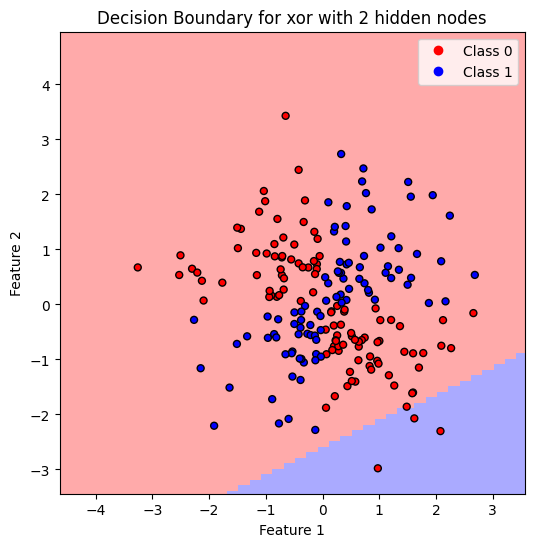

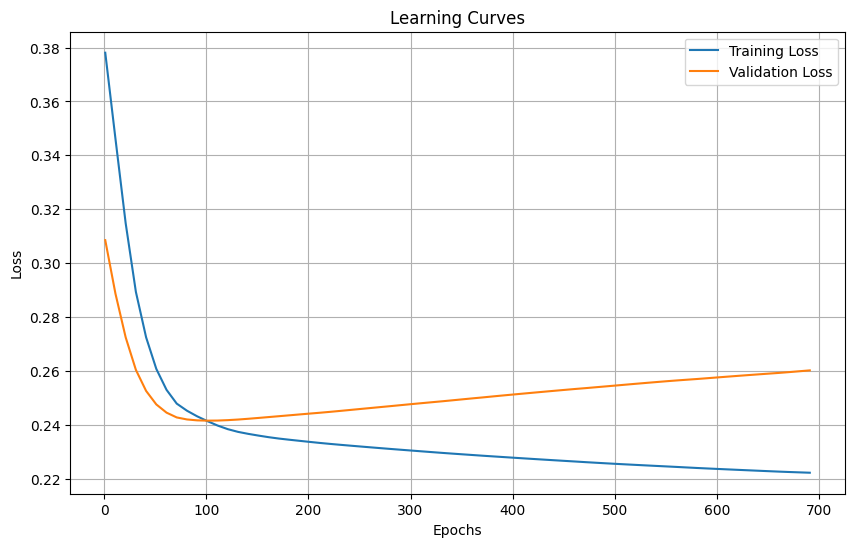


Training with k=3 hidden nodes
Early stopping at epoch 917 with validation loss: 0.2993
Model accuracy on test set: 64.50%


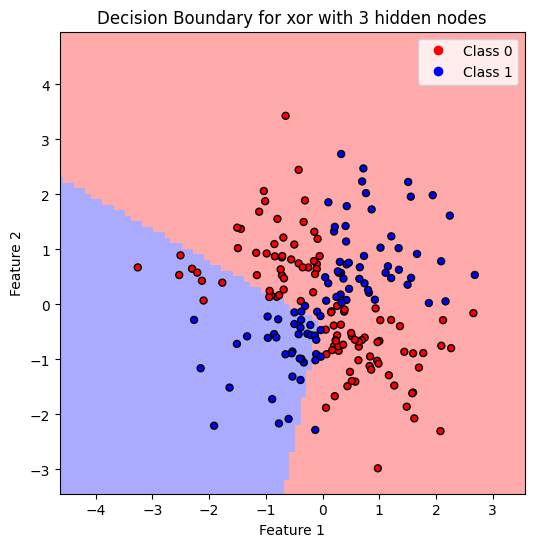

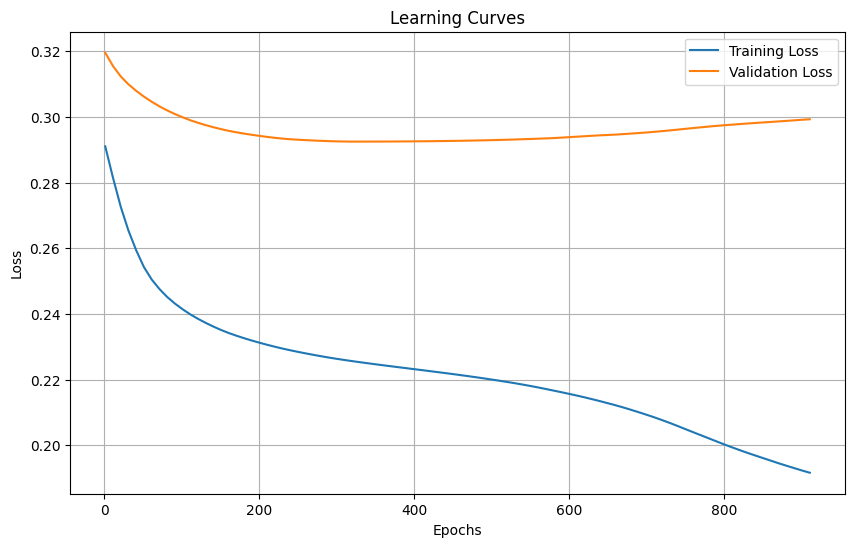


Training with k=5 hidden nodes
Early stopping at epoch 671 with validation loss: 0.3345
Model accuracy on test set: 85.50%


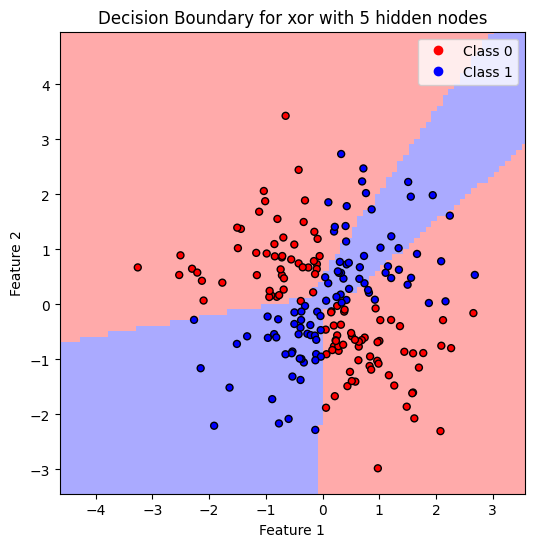

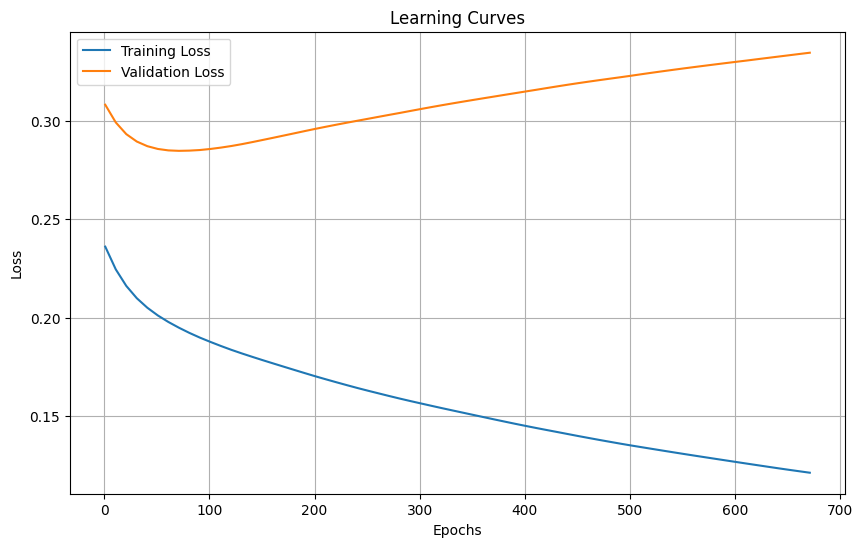


Training with k=7 hidden nodes
Early stopping at epoch 696 with validation loss: 0.3532
Model accuracy on test set: 91.50%


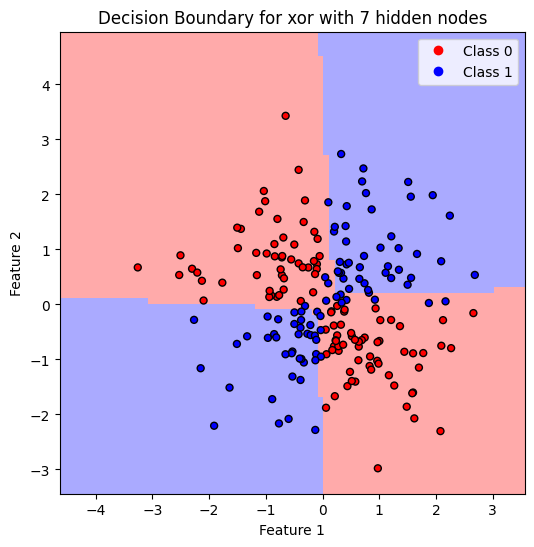

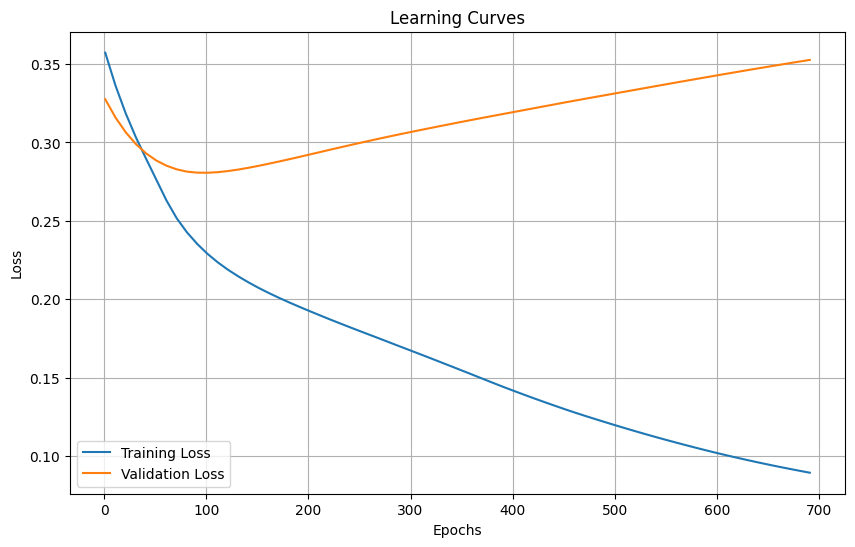


Training with k=9 hidden nodes
Early stopping at epoch 845 with validation loss: 0.3375
Model accuracy on test set: 87.00%


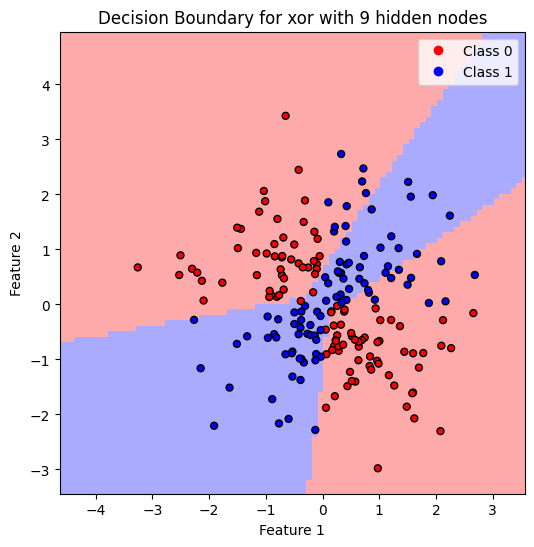

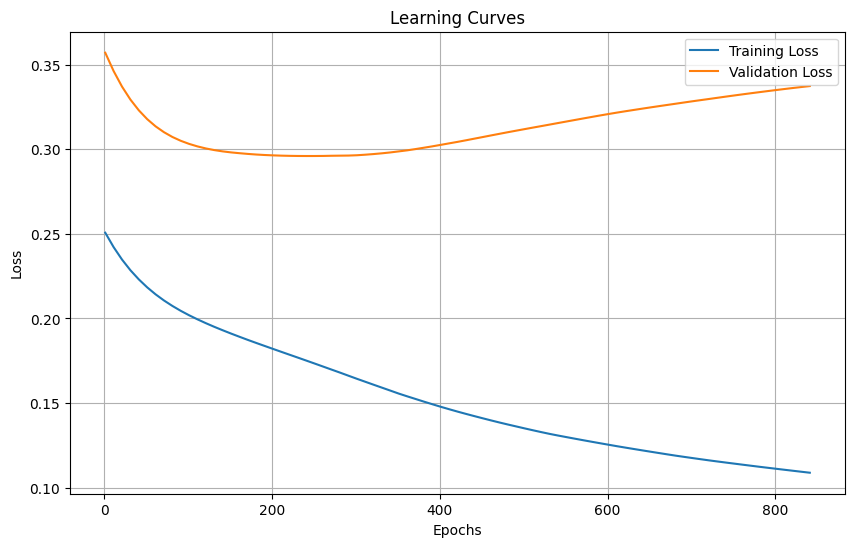

In [ ]:
name = 'xor'

x_train, y_train, _ = read_data(name, 'train')
# Testing different values of k for hidden nodes
input_size = x_train.shape[1]  # Number of features
output_size = len(np.unique(y_train))  # Number of classes (for one-hot encoding)
y_train_encoded = one_hot_encode(y_train, output_size)

x_test, y_test, label_test = read_data(name, 'test')  # Example with 'spiral' dataset
output_size = len(np.unique(y_test))
y_test_encoded = one_hot_encode(y_test, output_size)  # Ensure y_test is one-hot encoded


# Define hyperparameters
learning_rate = 0.02
epochs = 1000

for k in [2, 3, 5, 7, 9]:
    print(f"\nTraining with k={k} hidden nodes")
    model = FFNN(input_size=input_size, hidden_size=k, output_size=output_size, early_stopping_patience=600)
    train_losses, val_losses = model.train(x_train, y_train_encoded, epochs, x_test, y_test, learning_rate)

    final_loss = train_losses[-1]

    evaluator = Evaluator(model)
    accuracy = evaluator.evaluate(x_test, y_test_encoded)
    print(f"Model accuracy on test set: {accuracy * 100:.2f}%")
    my_draw(k,name,model=model)
    plot_learning_curves(train_losses, val_losses, epochs)


### Thoughts on the choice of optimal k number
#####   Underfitting with too few nodes (k = 5 and less): With fewer hidden nodes, the model lacks the capacity to learn the complex patterns required for XOR, leading to underfitting and low accuracy.

#####   Overfitting or instability with too many nodes (k = 9): Increasing the number of nodes to 9 provides greater flexibility, but as seen, it does not improve accuracy. Due to high variance, the model might overfit or fail to generalize, resulting in poor decision boundaries and lower accuracy.

#####   Moderate performance with k = 7: A model with 7 hidden nodes achieves a balance, displaying a more adaptable decision boundary and better accuracy, though still not ideal. An accuracy rate of 52.50% indicates it captures more information than other configurations..

### **Center_surround Dataset**


Training with k=2 hidden nodes
Model accuracy on test set: 61.50%


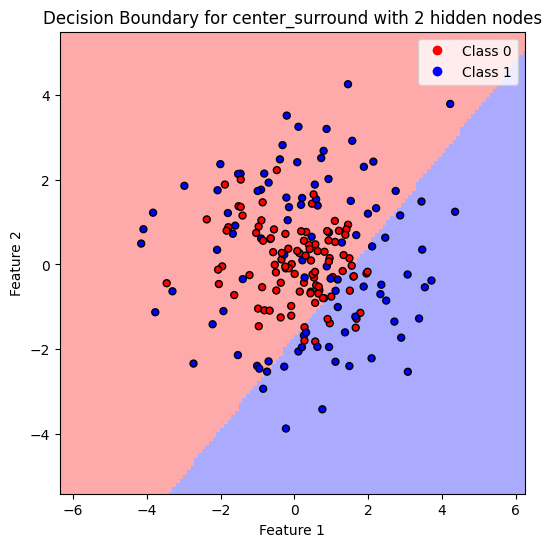

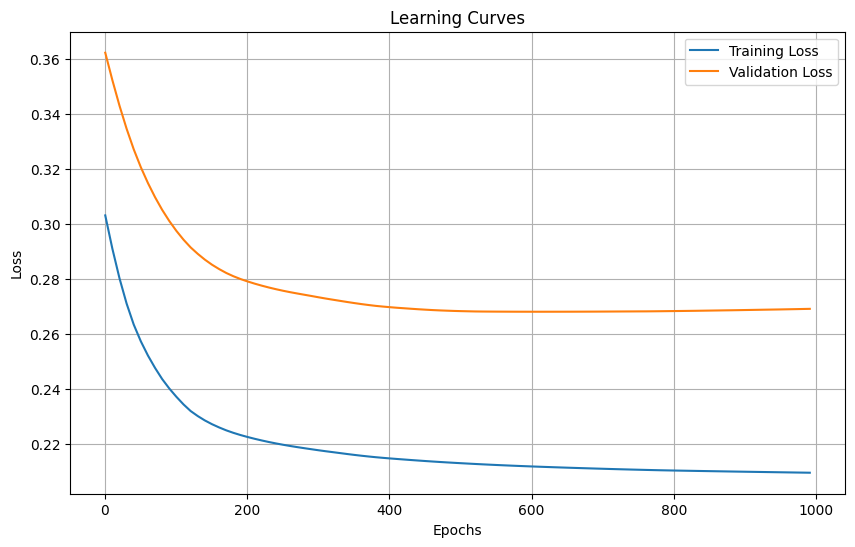


Training with k=3 hidden nodes
Model accuracy on test set: 68.50%


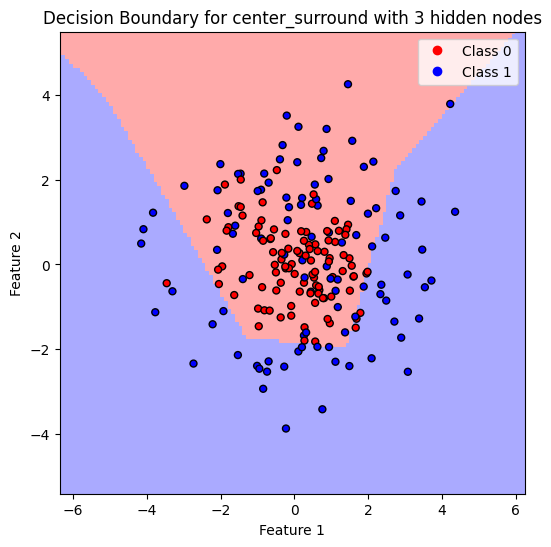

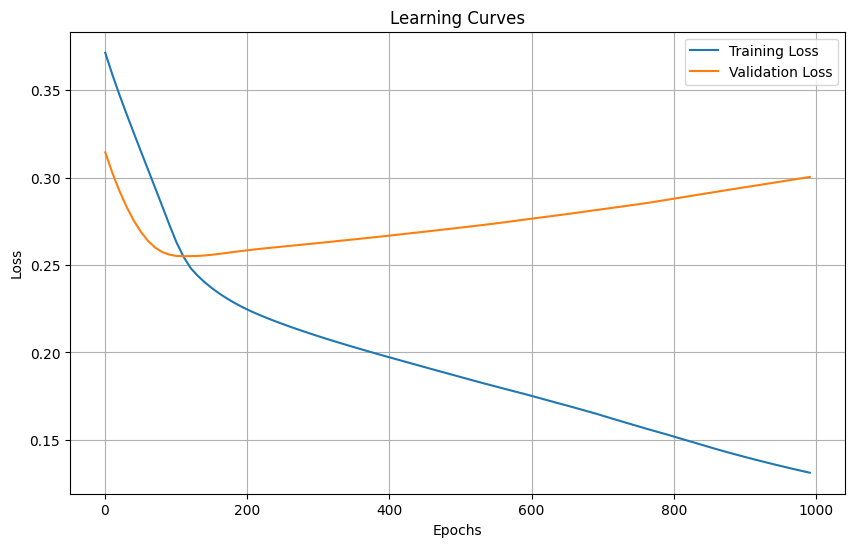


Training with k=5 hidden nodes
Model accuracy on test set: 69.00%


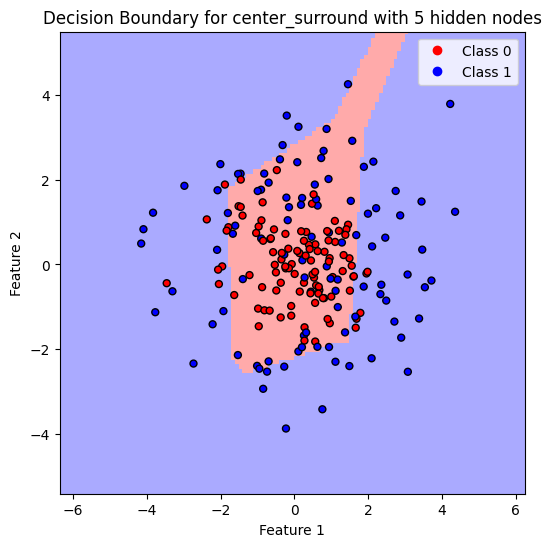

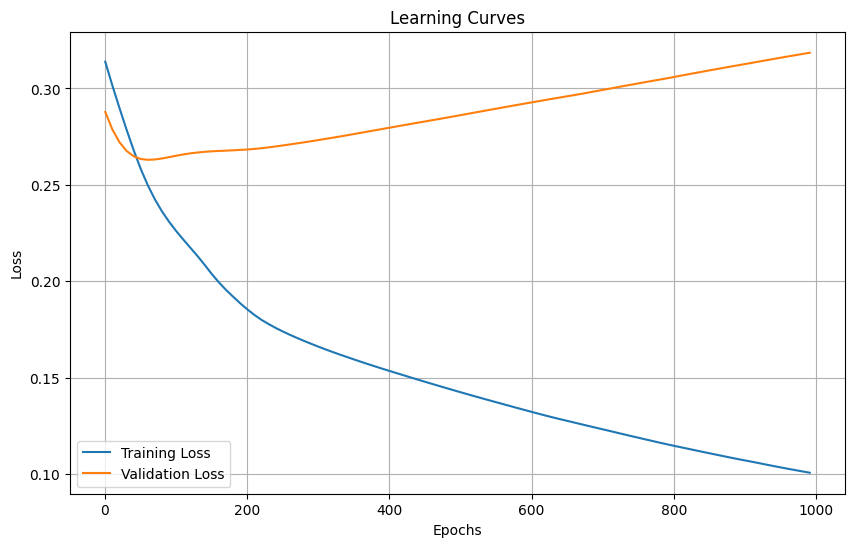


Training with k=7 hidden nodes
Model accuracy on test set: 73.00%


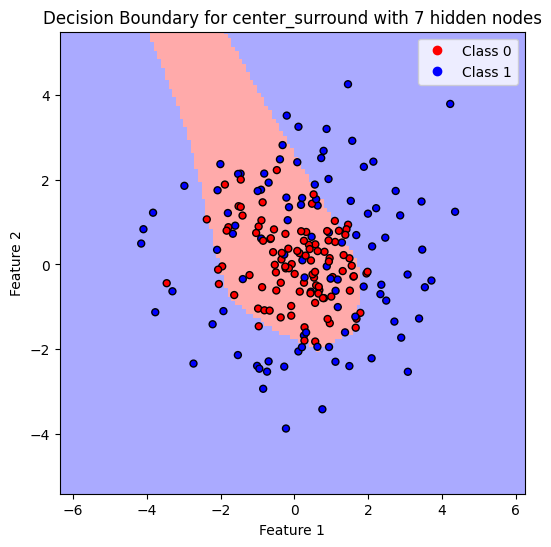

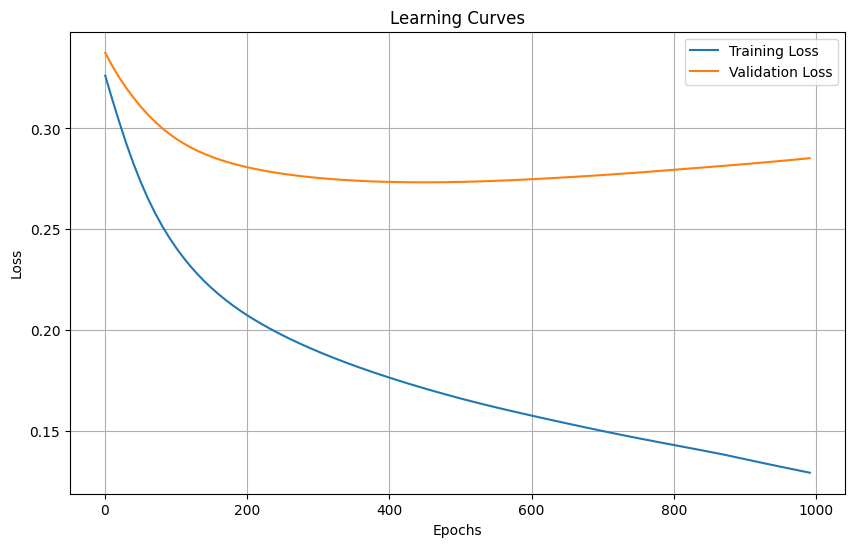


Training with k=9 hidden nodes
Model accuracy on test set: 75.50%


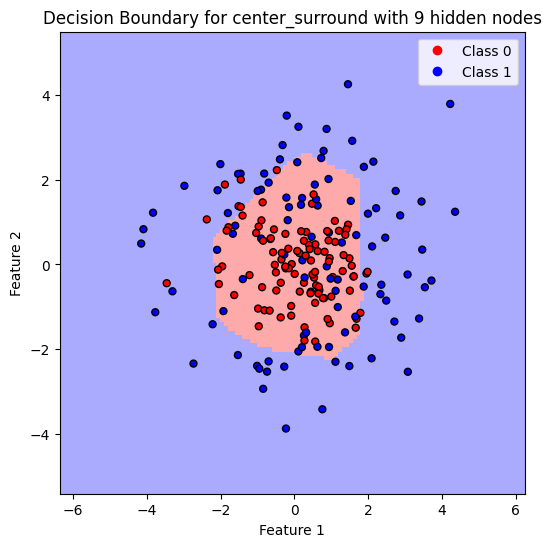

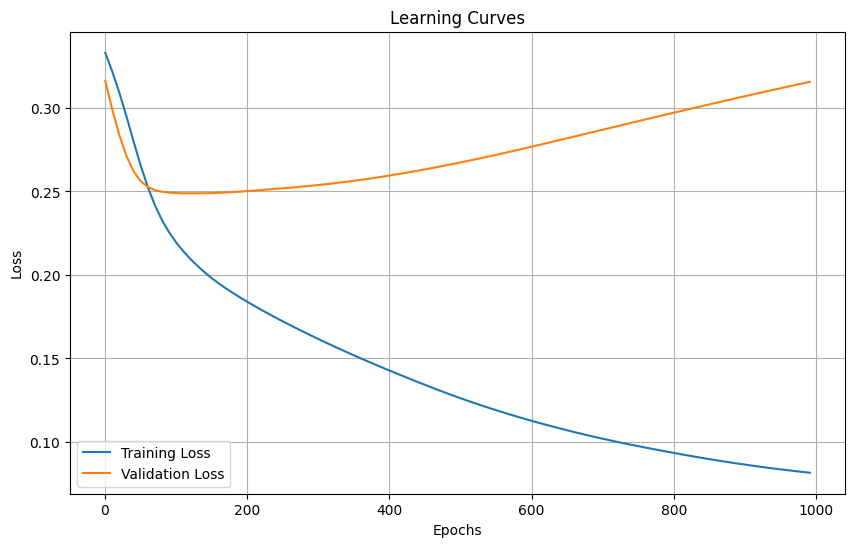

In [ ]:
name = 'center_surround'
x_train, y_train, _ = read_data(name, 'train')
# Testing different values of k for hidden nodes
input_size = x_train.shape[1]  # Number of features
output_size = len(np.unique(y_train))  # Number of classes (for one-hot encoding)
y_train_encoded = one_hot_encode(y_train, output_size)

x_test, y_test, label_test = read_data(name, 'test')  # Example with 'spiral' dataset
output_size = len(np.unique(y_test))
y_test_encoded = one_hot_encode(y_test, output_size)  # Ensure y_test is one-hot encoded


# Define hyperparameters
learning_rate = 0.01
epochs = 1000

for k in [2, 3, 5, 7, 9]:
    print(f"\nTraining with k={k} hidden nodes")
    model = FFNN(input_size=input_size, hidden_size=k, output_size=output_size, early_stopping_patience=1000)
    train_losses, val_losses = model.train(x_train, y_train_encoded, epochs, x_test, y_test, learning_rate)

    final_loss = train_losses[-1]

    evaluator = Evaluator(model)
    accuracy = evaluator.evaluate(x_test, y_test_encoded)
    print(f"Model accuracy on test set: {accuracy * 100:.2f}%")
    my_draw(k,name,model=model)
    plot_learning_curves(train_losses, val_losses, epochs)

### Thoughts on the choice of optimal k number
#####   For the 'center_surround' dataset, we found that when K=9, the model better fits the central distribution pattern in the data, with the decision boundary forming a circular shape. In contrast, configurations with K=2,3,5, and 7 do not align with this pattern.

####    So we choose K = 9

### **Two_gaussians Dataset**


Training with k=2 hidden nodes
Early stopping at epoch 204 with validation loss: 0.4431
Model accuracy on test set: 91.50%


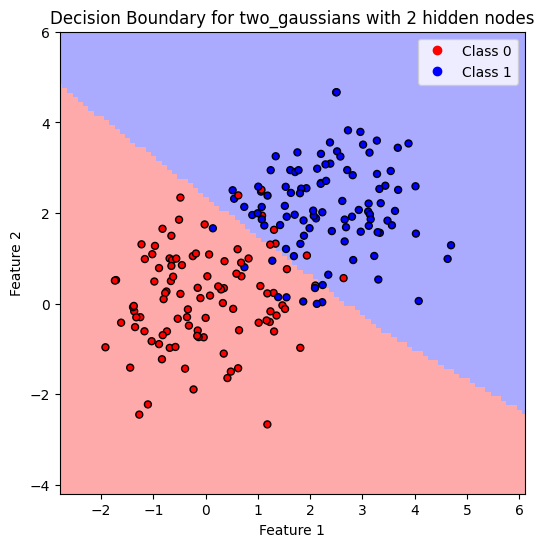

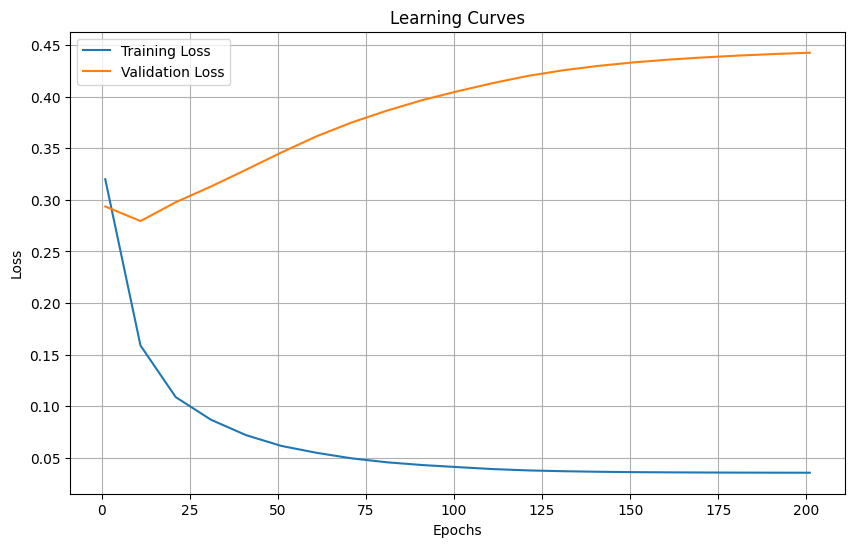


Training with k=3 hidden nodes
Early stopping at epoch 201 with validation loss: 0.4009
Model accuracy on test set: 91.50%


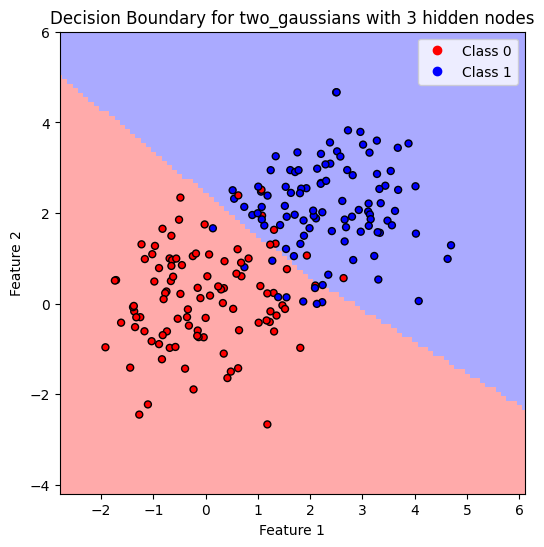

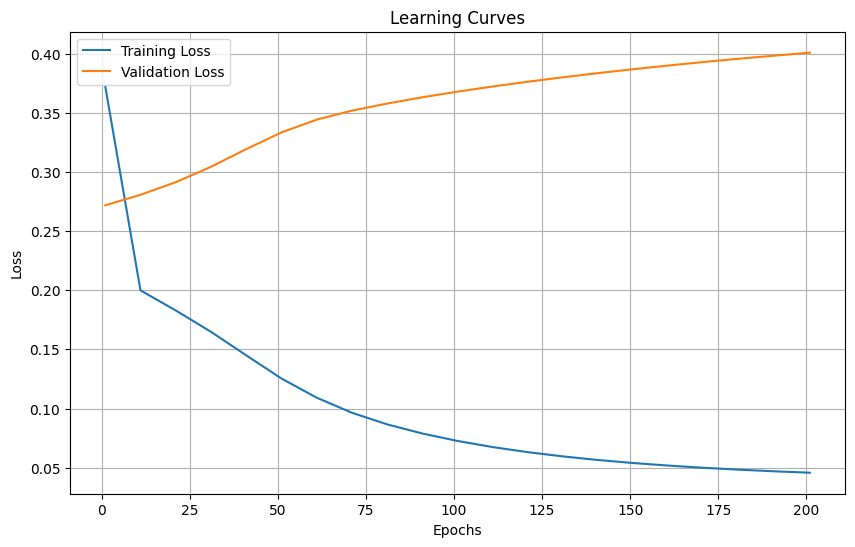


Training with k=5 hidden nodes
Early stopping at epoch 203 with validation loss: 0.4429
Model accuracy on test set: 91.00%


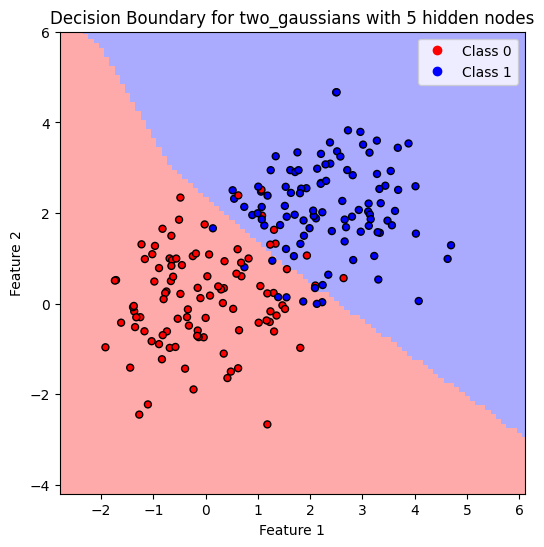

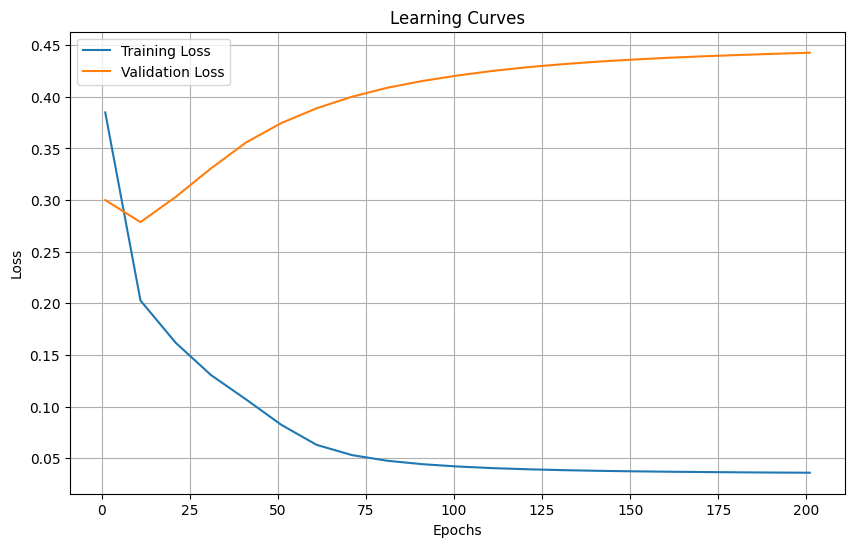


Training with k=7 hidden nodes
Early stopping at epoch 218 with validation loss: 0.4478
Model accuracy on test set: 91.50%


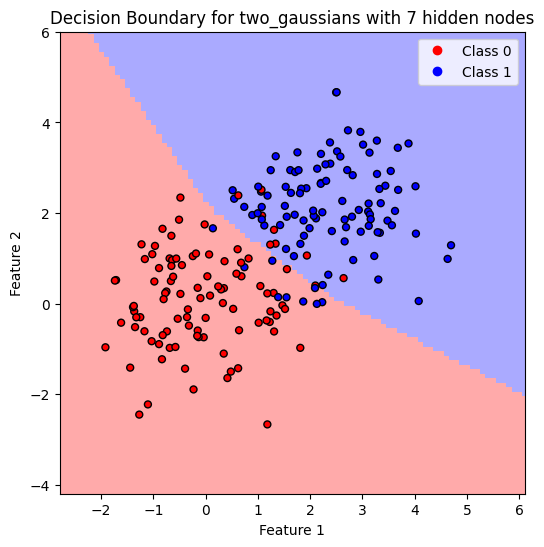

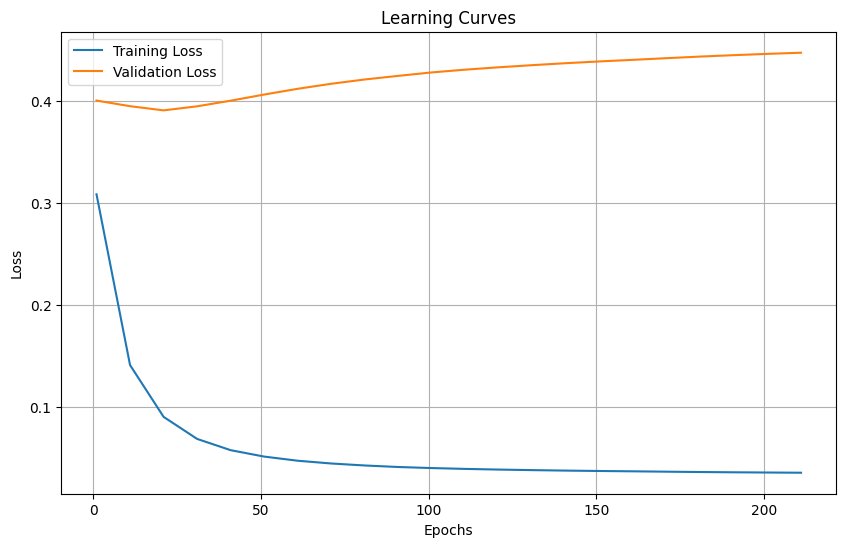


Training with k=9 hidden nodes
Early stopping at epoch 210 with validation loss: 0.4437
Model accuracy on test set: 91.00%


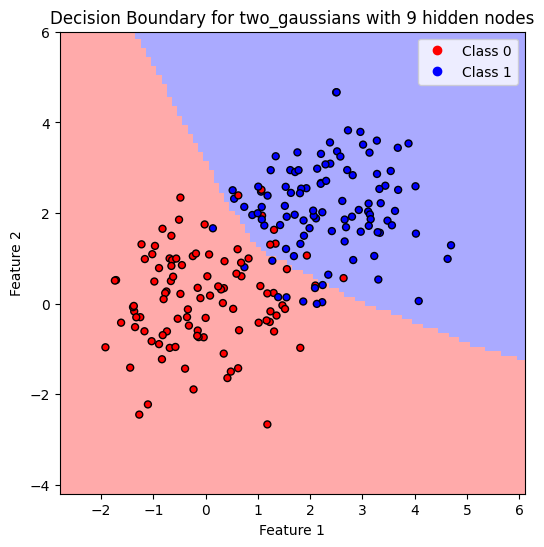

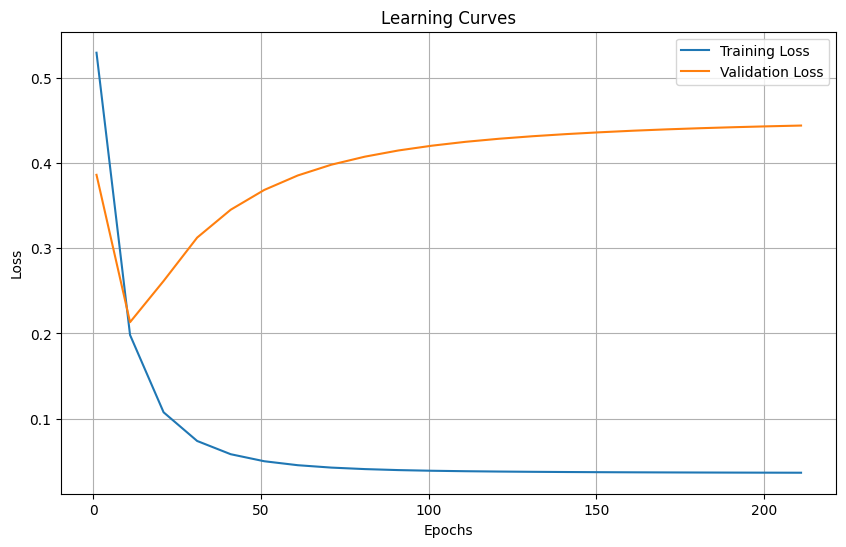

In [ ]:
name = 'two_gaussians'
x_train, y_train, _ = read_data(name, 'train')
# Testing different values of k for hidden nodes
input_size = x_train.shape[1]  # Number of features
output_size = len(np.unique(y_train))  # Number of classes (for one-hot encoding)
y_train_encoded = one_hot_encode(y_train, output_size)

x_test, y_test, label_test = read_data(name, 'test')  # Example with 'spiral' dataset
output_size = len(np.unique(y_test))
y_test_encoded = one_hot_encode(y_test, output_size)  # Ensure y_test is one-hot encoded


# Define hyperparameters
learning_rate = 0.1
epochs = 1000

for k in [2, 3, 5, 7, 9]:
    print(f"\nTraining with k={k} hidden nodes")
    model = FFNN(input_size=input_size, hidden_size=k, output_size=output_size)
    train_losses, val_losses = model.train(x_train, y_train_encoded, epochs, x_test, y_test, learning_rate)

    final_loss = train_losses[-1]

    evaluator = Evaluator(model)
    accuracy = evaluator.evaluate(x_test, y_test_encoded)
    print(f"Model accuracy on test set: {accuracy * 100:.2f}%")
    my_draw(k,name,model=model)
    plot_learning_curves(train_losses, val_losses, epochs)

### Thoughts on the choice of optimal k number

####    The 'two_gaussians' dataset favors selecting K=2 because increasing the K value does not result in significant improvements in performance. Opting for a smaller K aligns with the principles of generalization and model simplicity, following Occam's Razor, which suggests that simpler models are preferable when additional complexity does not provide clear benefits.

### **Spiral Dataset**


Training with k=2 hidden nodes
Model accuracy on test set: 77.00%


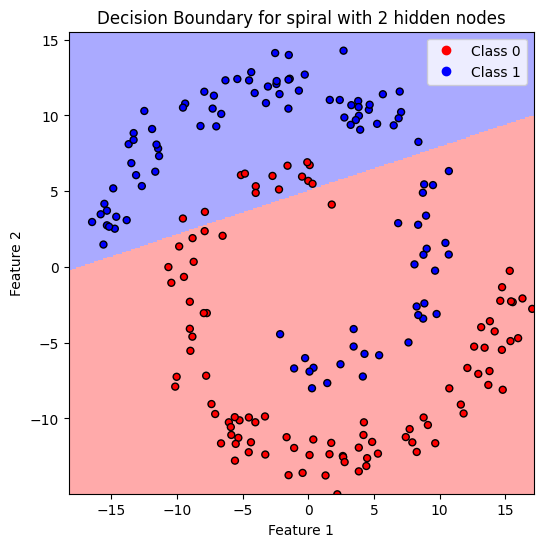

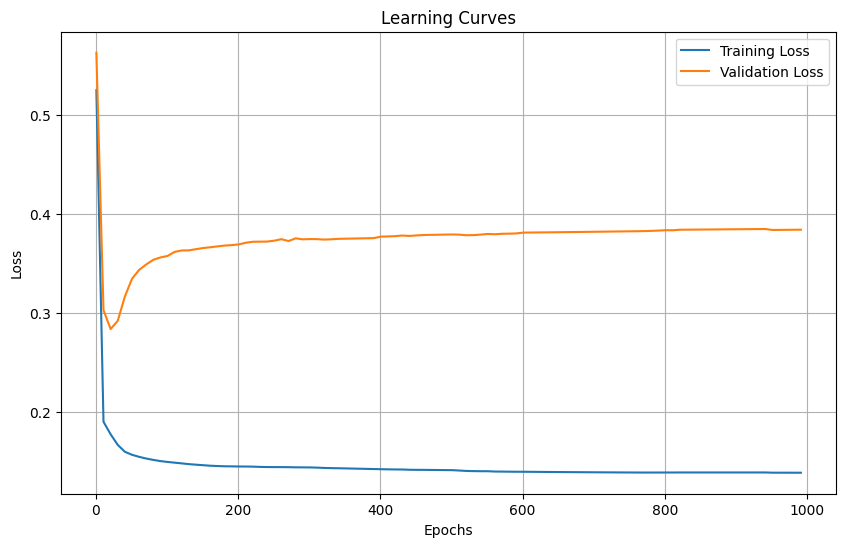


Training with k=3 hidden nodes
Model accuracy on test set: 84.00%


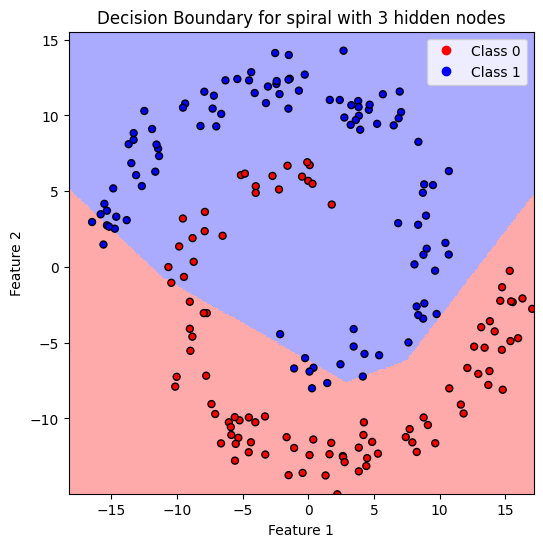

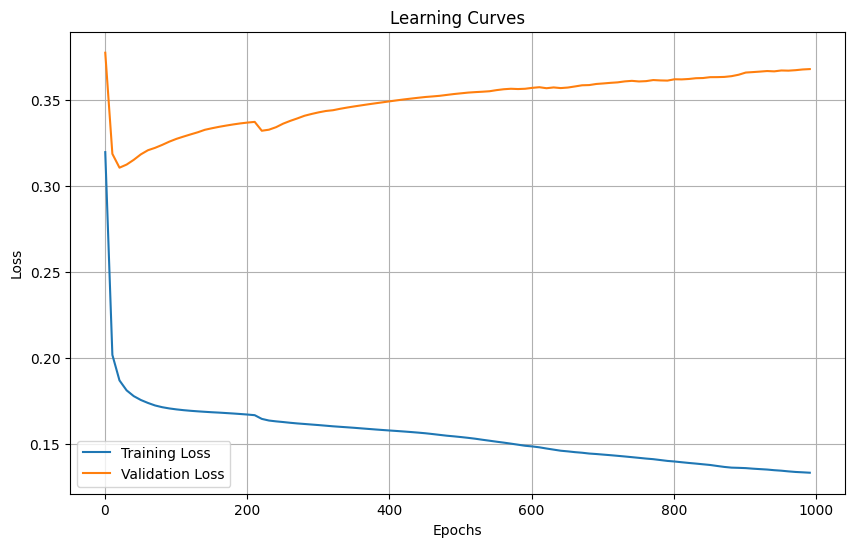


Training with k=5 hidden nodes
Model accuracy on test set: 93.00%


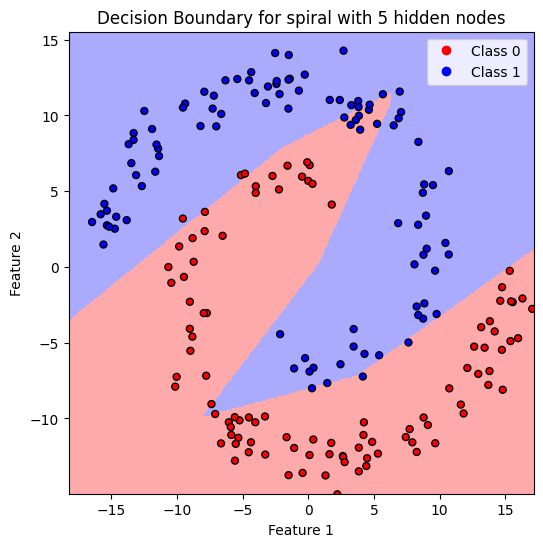

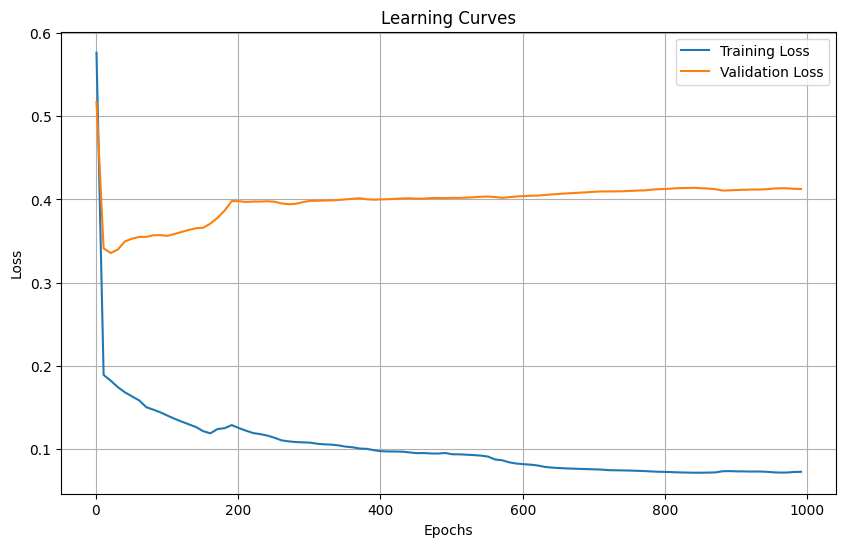


Training with k=7 hidden nodes
Model accuracy on test set: 99.50%


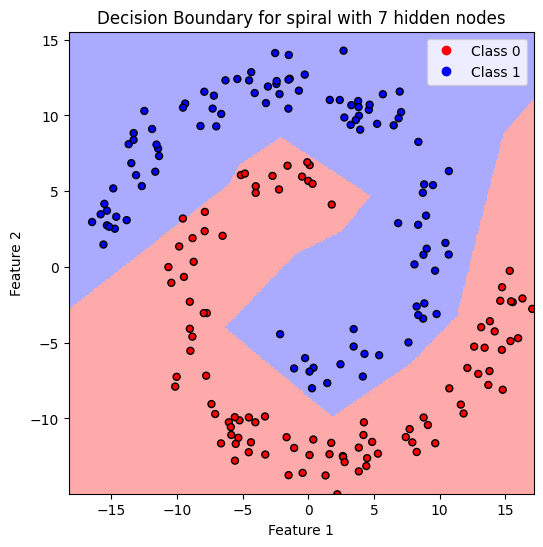

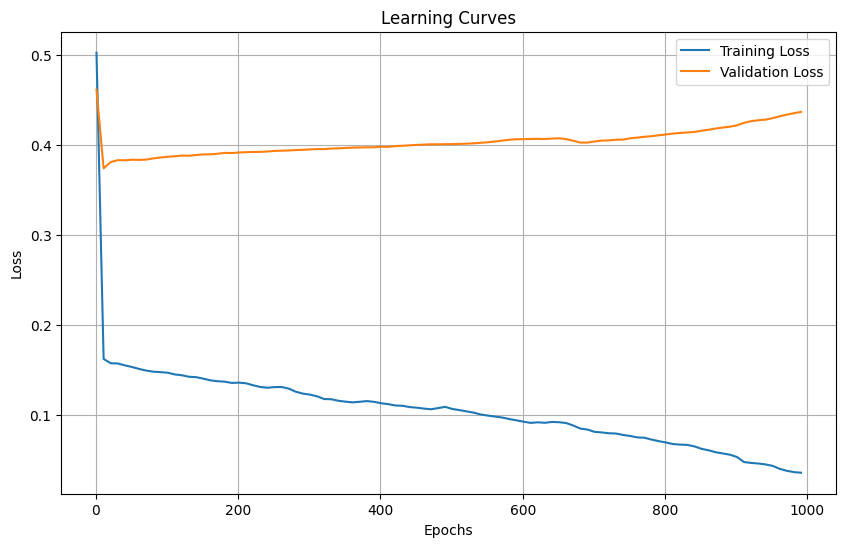


Training with k=9 hidden nodes
Model accuracy on test set: 93.50%


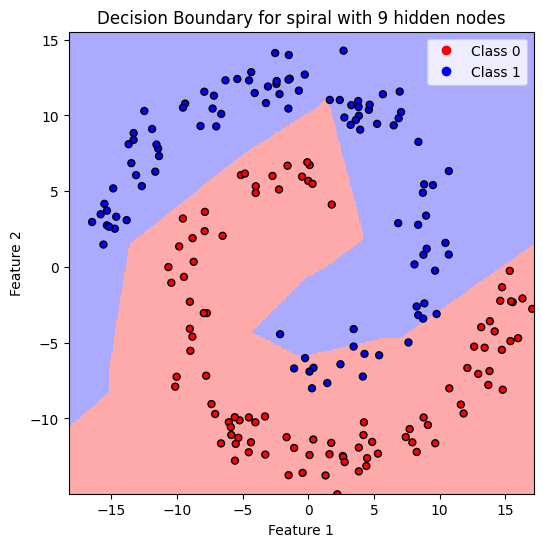

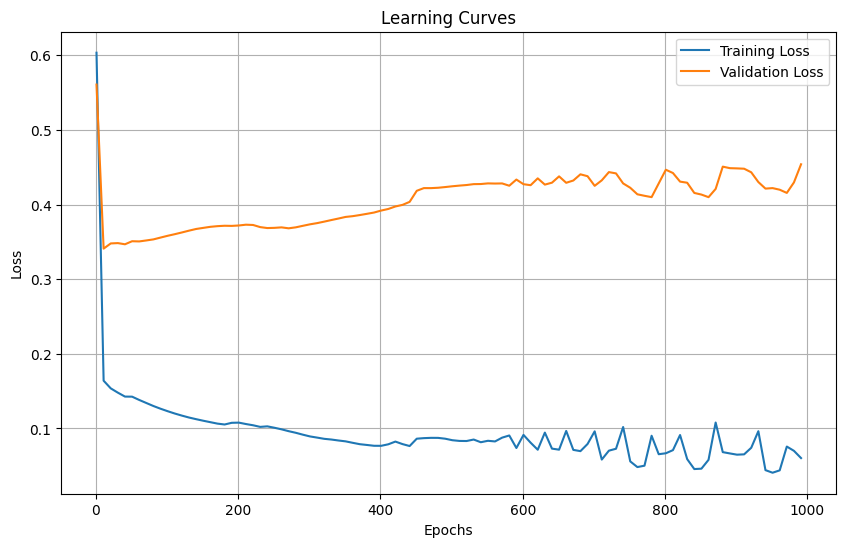

In [ ]:
name = 'spiral'
x_train, y_train, _ = read_data(name, 'train')
# Testing different values of k for hidden nodes
input_size = x_train.shape[1]  # Number of features
output_size = len(np.unique(y_train))  # Number of classes (for one-hot encoding)
y_train_encoded = one_hot_encode(y_train, output_size)

x_test, y_test, label_test = read_data(name, 'test')  # Example with 'spiral' dataset
output_size = len(np.unique(y_test))
y_test_encoded = one_hot_encode(y_test, output_size)  # Ensure y_test is one-hot encoded


# Define hyperparameters
learning_rate = 0.1
epochs = 1000

for k in [2, 3, 5, 7, 9]:
    print(f"\nTraining with k={k} hidden nodes")
    model = FFNN(input_size=input_size, hidden_size=k, output_size=output_size)
    train_losses, val_losses = model.train(x_train, y_train_encoded, epochs, x_test, y_test, learning_rate)

    final_loss = train_losses[-1]

    evaluator = Evaluator(model)
    accuracy = evaluator.evaluate(x_test, y_test_encoded)
    print(f"Model accuracy on test set: {accuracy * 100:.2f}%")
    my_draw(k,name,model=model)
    plot_learning_curves(train_losses, val_losses, epochs)

### Thoughts on the choice of optimal k number

####    The spiral pattern is highly non-linear, and thus, a sufficient number of hidden nodes is required to model the intricate decision boundary. A lower K might not capture this complexity, leading to underfitting.

####    Compared to K=9 and K=5, the model with K=7 demonstrates a smoother decision boundary and achieves a higher accuracy. When K=9, the increased number of hidden nodes adds complexity, which can sometimes lead to a more jagged or fragmented decision boundary due to overfitting. This complexity may cause the model to capture noise or less relevant details, reducing its ability to generalize effectively.

####    As seen in the plot, the model with K=7 produces a smooth, coherent decision boundary that separates the classes effectively. This indicates that K=7 provides an adequate balance between model flexibility and accuracy.

### Thoughts on the choice of optimal k number

####    The spiral pattern is highly non-linear, and thus, a sufficient number of hidden nodes is required to model the intricate decision boundary. A lower K might not capture this complexity, leading to underfitting.

####    Compared to K=9 and K=5, the model with K=7 demonstrates a smoother decision boundary and achieves a higher accuracy. When K=9, the increased number of hidden nodes adds complexity, which can sometimes lead to a more jagged or fragmented decision boundary due to overfitting. This complexity may cause the model to capture noise or less relevant details, reducing its ability to generalize effectively.

####    As seen in the plot, the model with K=7 produces a smooth, coherent decision boundary that separates the classes effectively. This indicates that K=7 provides an adequate balance between model flexibility and accuracy.